# Urban Sound Classification: Deep Learning Approaches for Audio Recognition
## Machine Learning II
#### Work assembled by Beatriz Pereira, Carolina Leite, Lara Gonçalves

### Table of contents <a name="contents"></a>
1. [Introduction](#introduction)
2. [Data Understanding](#data-understanding)
3. [Data Reading](#data-reading)
    - 3.1. [Feature Extraction](#feature-extraction)
    - 3.2. [Data Cleaning](#data-cleaning)
      
      - 3.2.1. [Reading](#reading)
      
      - 3.2.2. [Cleaning](#cleaning)
     
4. [Modeling](#modeling)

## 1. Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

The objective of this project is to develop **deep learning classifiers** for urban sound data. In this assignment, we will implement two of the three classifiers provided by the professor, as outlined in the [[PDF]](AC2_Project_20252026.pdf). 

The classifiers are:

• A classifier based on a multilayer perceptron (MLP)

• A classifier based on a convolutional neural network (CNN)

• A classifier based on a recurrent neural network (RNN)

And for each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation

#### Imports

In [4]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import librosa
from scipy.io import wavfile as wav
import os
import numpy as np
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd 
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## 2. Data Understanding <a name="data-understanding"></a>
[[go back to the top]](#contents)

The dataset consists of 8,732 labeled sound excerpts, each lasting up to 4 seconds, categorized into 10 distinct classes:
- air_conditioner [0] 
- car_horn [1] 
- children_playing [2] 
- dog_bark [3] 
- drilling [4] 
- enginge_idling [5] 
- gun_shot [6] 
- jackhammer [7] 
- siren [8] 
- street_music [9] 

The sound classes in the UrbanSound and UrbanSound8K datasets are derived from the UrbanSound taxonomy, as presented on the https://urbansounddataset.weebly.com/taxonomy.html

Below is an image showcasing the taxonomy structure from the referenced site:

![Urban_Sound_Taxonomy](./images/urban_sound_taxonomy.png)

All audio excerpts are derived from field recordings uploaded to http://www.freesound.org/

The dataset comprises 8,732 urban sound audio files in WAV format. The sampling rate, bit depth, and number of channels correspond to those of the original files uploaded to Freesound, which may vary across different recordings.

In addition to the audio excerpts, a CSV file containing metadata for each excerpt is also included.

This is a short explanation of the csv:

| Name of the Column | Brief Explanation                                                                                       |
|--------------------|--------------------------------------------------------------------------------------------------------|
| slice_file_name    | The name of the audio file, formatted as [fsID]-[classID]-[occurrenceID]-[sliceID].wav.              |
| fsID               | The Freesound ID of the recording from which this excerpt (slice) is taken.                           |
| start              | The start time of the slice in the original Freesound recording.                                      |
| end                | The end time of the slice in the original Freesound recording.                                        |
| salience           | A subjective salience rating of the sound (1 = foreground, 2 = background).                           |
| fold               | The fold number (1-10) to which this file has been allocated.                                         |
| classID            | A numeric identifier of the sound class (0-9) as listed above.                                        |
| [occurrenceID]     | A numeric identifier to distinguish different occurrences of the sound within the original recording. |
| [sliceID]          | A numeric identifier to distinguish different slices taken from the same occurrence.                 |


**To avoid common pitfalls**:
-  Don't reshuffle the data! Use the predefined 10 folds and perform 10-fold (not 5-fold) cross validation
-  Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores

## 3. Data Reading <a name="data-reading"></a>
[[go back to the top]](#contents)


After carefully analyzing the three available classifiers, we decided to implement CNN and RNN for this project. Our decision was based on several important considerations, which we have outlined in detail in the following [[Summary]](Research/Summary.md).


### Librosa vs Scipy.io

**Librosa:** is a library specialized in audio analysis and manipulation for machine learning and digital signal processing. It provides a wide range of tools aimed at feature extraction and audio representations.

- Pros:
    - Supports various audio formats (.wav, .mp3, etc.).
    - Advanced feature extraction: Mel Spectrograms, MFCCs, Chromagrams.
    - Easy audio manipulation (resampling, padding, normalization).
    - Integration with visualizations (spectrograms, MFCCs).

- Cons:
    - Slower for simple tasks (loading/saving audio).
    - Steeper learning curve for beginners.
    - Depends on external libraries (audioread, ffmpeg).

**Scipy.io:** is part of the SciPy library and is a simple and efficient tool for reading and writing .wav files. It is useful for basic audio manipulation tasks.

- Pros:
    - Simple, fast, and efficient for loading/saving .wav files.
    - Direct integration with NumPy for basic manipulation.

- Cons:
    - Limited to .wav files.
    - Does not support advanced feature degradation.
    - Does not offer resampling, padding, or integrated views.

Let's briefly analyze the differences between librosa and scipy.io.

In [6]:
filename = r"UrbanSound8K/audio/fold1/7061-6-0-0.wav"

In [7]:
librosa_audio, librosa_sample_rate = librosa.load(filename)
scipy_sample_rate, scipy_audio = wav.read(filename)

c:\ProgramData\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [8]:
print("Librosa sample wave rate:", librosa_sample_rate)
print("Scipy sample wave rate : " , scipy_sample_rate )

Librosa sample wave rate: 22050
Scipy sample wave rate :  44100


In [9]:
print("Librosa audio signal " , librosa_audio)
print("Librosa audio data type:", librosa_audio.dtype)
print()
print("Scipy audio signal" , scipy_audio)
print("Scipy audio data type:", scipy_audio.dtype)

Librosa audio signal  [-7.4505806e-09  2.9802322e-08  4.8428774e-08 ...  1.0127544e-05
  2.3271263e-05  7.0009992e-06]
Librosa audio data type: float32

Scipy audio signal [[0 0]
 [0 0]
 [0 0]
 ...
 [1 0]
 [1 1]
 [0 0]]
Scipy audio data type: int16


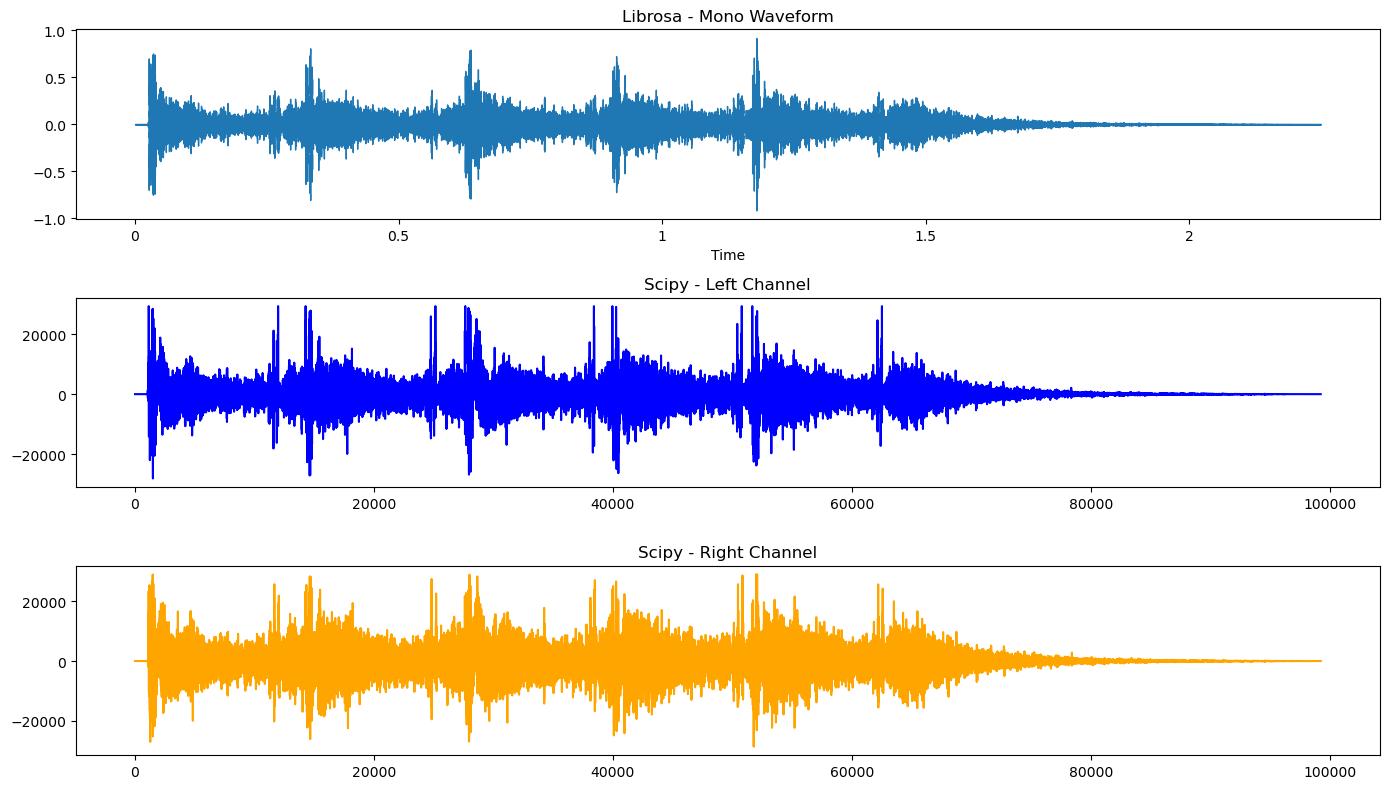

In [10]:
plt.figure(figsize=(14, 8))  # Ajuste o tamanho da figura para mais altura

# Plot librosa mono waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(librosa_audio, sr=librosa_sample_rate)
plt.title("Librosa - Mono Waveform")

# Plot scipy stereo waveform (each channel separately if stereo)
# Plot left and right channels in separate subplots
plt.subplot(3, 1, 2)
if scipy_audio.ndim > 1:  # Stereo
    plt.plot(scipy_audio[:, 0], label="Left Channel", color='blue')
    plt.title("Scipy - Left Channel")

    plt.subplot(3, 1, 3)
    plt.plot(scipy_audio[:, 1], label="Right Channel", color='orange')
    plt.title("Scipy - Right Channel")
else:  # Mono
    plt.plot(scipy_audio)
    plt.title("Scipy - Mono Waveform")

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

Taking into account all the pros and cons previously mentioned, we decided that for this work **we will use librosa**, as it offers more advantages for this type of project. Furthermore, it allows, by default, converting all audio to a sampling rate of 22050 Hz (normally used in audio learning and processing models), converting audio into a single signal (mono sound), and also normalizing audio, unlike scipy, which converts audio into arrays.

In [11]:
path_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'

df = pd.read_csv(path_csv)

df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

##### Check if there's any missing values

In [12]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


As we can see, the dataset **does not contain any null values**, which is great considering that this means there is no missing data, and therefore it is possible to know the correct classification of each audio file.

##### Check if there's any duplicate values

In [13]:
duplicates = df.duplicated()
print(f"Duplicates values: {duplicates.sum()}")

Duplicates values: 0


There are also **no duplicate values**, meaning that each audio file in the dataset, even if it comes from the same original FreeSound audio, is not identical to any other, as it corresponds to different slices within the audio.

##### Data Consistency

Although there appear to be no problems with the data, according to the audio metadata, we need to confirm if, for any reason, there is a file listed in the metadata that does not appear in the audio directory, or if there is any audio that does not appear in the metadata.

In [15]:
audios_dir = r"UrbanSound8K/audio"

Let's start by testing if all the audio files described in the metadata are located in the correct folders:

In [16]:
# Initialize list of missing files
missing_files = []

for index, row in df.iterrows():
    # Build the expected file path
    fold = row['fold']
    folder_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, folder_name, file_name)
    
    # Check if file exists
    if not os.path.isfile(file_path):
        missing_files.append(file_path)

# Show missing files
if missing_files:
    print(f"Missing files ({len(missing_files)}):")
    for file in missing_files:
        print(file)
else:
    print("All files are present.")

All files are present.


Now, let's check if there are any extra files in the different folds:

In [17]:
# Initialize list of extra files
extra_files = []

for fold in range(1, 11):  # Folders 1 to 10
    folder_name = "folder" + str(fold)
    folder_path = os.path.join(audios_dir, folder_name)
    if os.path.exists(folder_path):
        # List all files in folder
        files_in_folder = os.listdir(folder_path)
        # Filter only audio files
        audio_files = [f for f in files_in_folder if f.endswith('.wav')]
        
        # Compare with files listed in CSV
        expected_files = df[df['fold'] == fold]['slice_file_name'].tolist()
        for audio_file in audio_files:
            if audio_file not in expected_files:
                extra_files.append(os.path.join(folder_path, audio_file))

# Show extra files
if extra_files:
    print(f"Extra files ({len(extra_files)}):")
    for file in extra_files:
        print(file)
else:
    print("No extra files found.")


No extra files found.


As we can see, there are no inconsistencies between the data described in the metadata and the audio files we have. We can therefore proceed to a more detailed analysis of the data.

c:\ProgramData\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


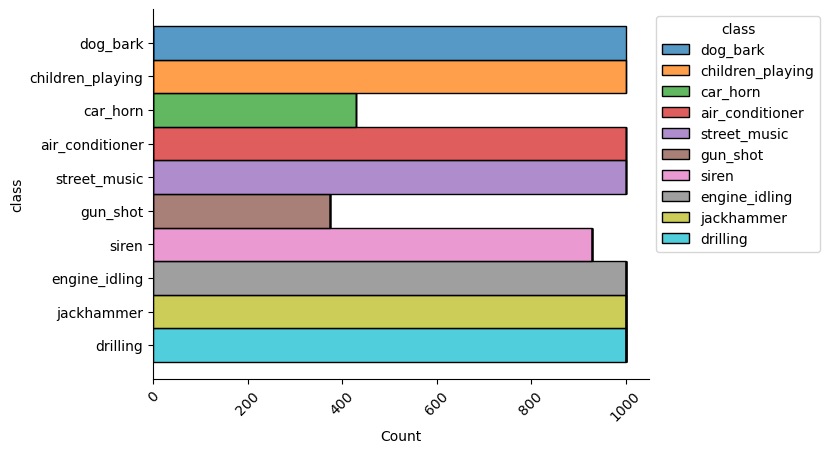

In [18]:
ax = sns.histplot(y='class',data = df, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
sns.despine()
plt.show()

In [19]:
class_dict = df['class'].value_counts(normalize=True)

In [20]:
class_dict

class
dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: proportion, dtype: float64

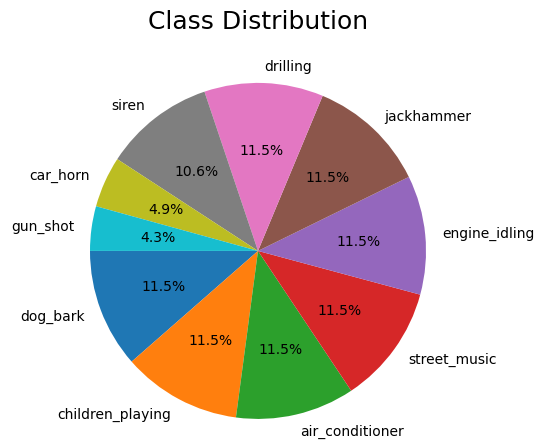

In [21]:
classes = class_dict.index
values = class_dict.values

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(values, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show(block=False)

Although the **'car_horn'** and **'gun_shot'** classes have fewer entries, and therefore fewer audio files of those types, the dataset appears to be minimally balanced, so no changes are necessary.

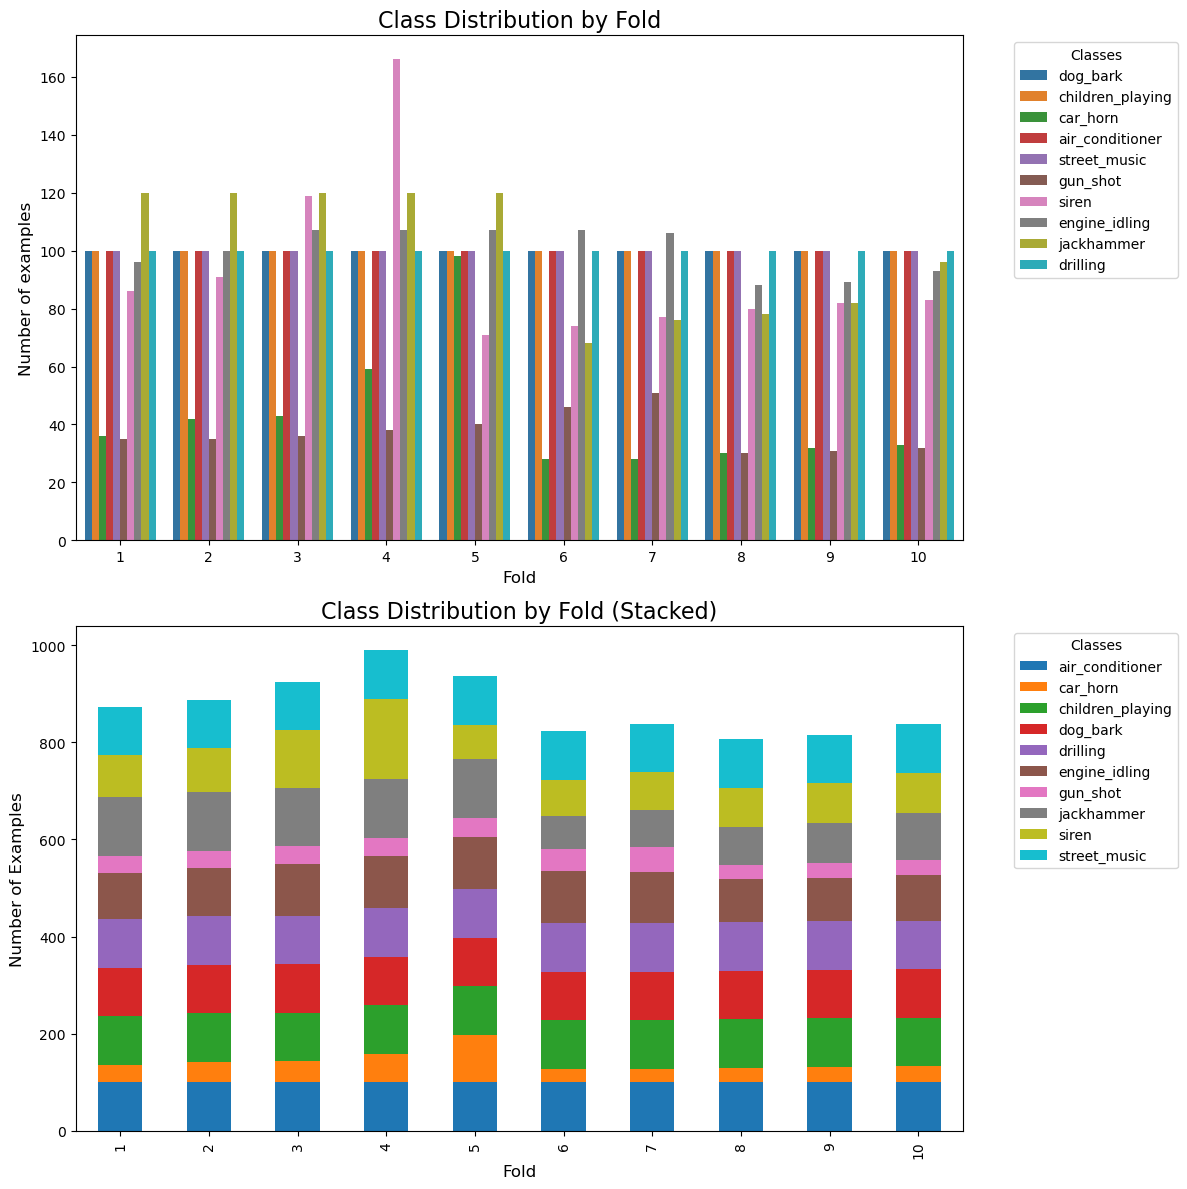

In [22]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Color palette
palette = sns.color_palette("tab10")

# First graphic: Countplot
sns.countplot(
    data=df, 
    x='fold', 
    hue='class', 
    palette=palette, 
    ax=axes[0]
)
axes[0].set_title('Class Distribution by Fold', fontsize=16)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Number of examples', fontsize=12)
axes[0].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Count number of examples of each class by fold
class_fold_distribution = df.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Second graphics: Stacked bars
class_fold_distribution.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab10',
    ax=axes[1]
)
axes[1].set_title('Class Distribution by Fold (Stacked)', fontsize=16)
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('Number of Examples', fontsize=12)
axes[1].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [23]:
appended = []
for i in range(1,11):
    appended.append(df[df.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

class   index  jackhammer  dog_bark  children_playing  street_music  \
0       fold1         120       100               100           100   
1       fold2         120       100               100           100   
2       fold3         120       100               100           100   
3       fold4         120       100               100           100   
4       fold5         120       100               100           100   
5       fold6          68       100               100           100   
6       fold7          76       100               100           100   
7       fold8          78       100               100           100   
8       fold9          82       100               100           100   
9      fold10          96       100               100           100   

class  air_conditioner  drilling  engine_idling  siren  car_horn  gun_shot  
0                  100       100             96     86        36        35  
1                  100       100            100     91        42        35  
2                  100       100            107    119        43        36  
3                  100       100            107    166        59        38  
4                  100       100            107     71        98        40  
5                  100       100            107     74        28        46  
6                  100       100            106     77        28        51  
7                  100       100             88     80        30        30  
8                  100       100             89     82        32        31  
9                  100       100             93     83        33        32

Although some classes have fewer entries than others, we can see that by fold the classes seem to be fairly evenly distributed, with approximately the same number of entries per class in each fold.

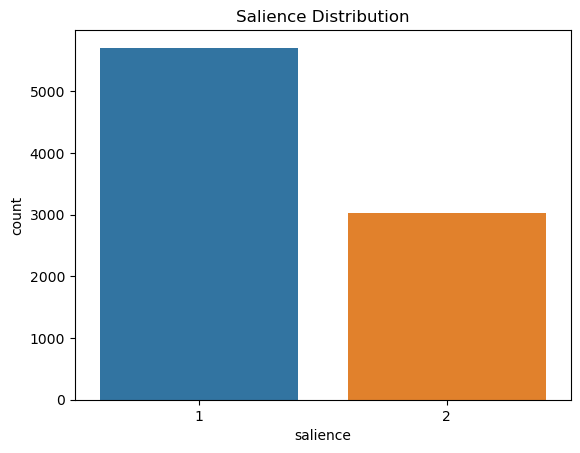

In [24]:
sns.countplot(data = df, x = 'salience')
plt.title('Salience Distribution')
plt.show()

We concluded that most of the audio files are classified as having been obtained from 'foreground' sources.

##### Audio Duration

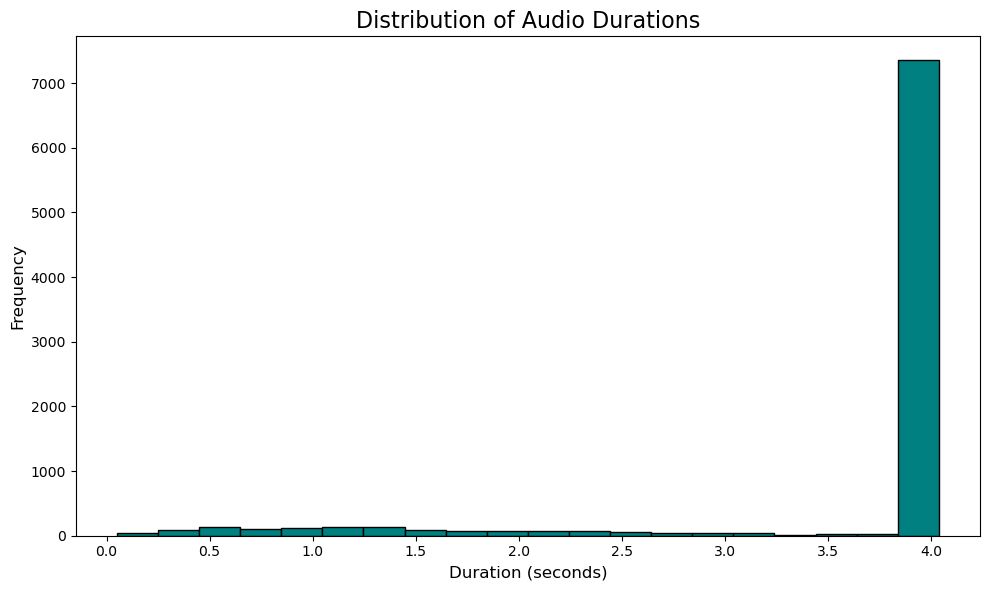

In [25]:
# List for storing durations
durations = []

# Process each audio
for index, row in df.iterrows():
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)
    
    if os.path.isfile(file_path):
        # Load audio
        y, sr = librosa.load(file_path, sr=None)  # sr=None para manter a taxa original
        # Get original duration
        durations.append(librosa.get_duration(y=y, sr=sr))
    else:
        print(f"File not found: {file_path}")

# Show duration distribution
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Audio Durations', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

##### Accessing the audio data

In [26]:
# Go through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Browse the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Upload audio using librosa
                audio, sample_rate = librosa.load(file_path)
                
                # Example: Process audio or extract features
                print(f"File: {file_name}, Sample Rate: {sample_rate}, Duration: {len(audio)/sample_rate:.2f}s")


File: 101415-3-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-8.wav, Sample Rate: 22050, Duration: 4.00s
File: 102106-3-0-0.wav, Sample Rate: 22050, Duration: 1.64s
File: 102305-6-0-0.wav, Sample Rate: 22050, Duration: 2.61s
File: 102842-3-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-5.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-6.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-4.wav, Sample Rate: 220

##### As observed, some audio clips have varying durations, such as 1.64, 2.61, and up to 4 seconds. To simplify the processing and ensure consistency, we will standardize all audio data to the same length. This allows for uniform input to our models, improving training efficiency and performance. How can we do that?

##### Well, there's four strategies:
- **Zeropadding:** Ideal for maintaining the integrity of short audios.
- **Audio Repetition:** Works well for rhythmic or repetitive sounds.
- **Discard Short Audios:** Simple and effective when you can afford to lose some data.
- **Interpolation:** Suitable if you want to maintain consistency in the timing of the audio, but can change the way it sounds.



### Nota: Falar com o professor para saber qual a melhor abordagem. Segundo as minhas pesquisas, penso que seja o Zeropadding. Mas Audio Repetition também pode ser uma opção. As outras penso que não sejam as melhores. Mas pronto!

Ass: Carolina

##### Zeropadding

In [27]:
# Target duration and sample rate
target_duration = 4.0  # seconds
sample_rate = 22050    # Hz
target_samples = int(target_duration * sample_rate)

for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    
    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")
        
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                
                file_path = os.path.join(fold_path, file_name)

                # Load audio
                audio, sr = librosa.load(file_path, sr=sample_rate)

                # Zero padding if shorter than target duration
                if len(audio) < target_samples:
                    padding_needed = target_samples - len(audio)
                    audio_padded = np.pad(audio, (0, padding_needed), mode='constant')
                else:
                    # Truncate if too long
                    audio_padded = audio[:target_samples]

                # Save padded/truncated audio
                sf.write(file_path, audio_padded, sample_rate)
                print(f"File {file_name} processed with duration of {target_duration} seconds.")


Processing files in UrbanSound8K/audio\fold1...
File 101415-3-0-2.wav processed with duration of 4.0 seconds.
File 101415-3-0-3.wav processed with duration of 4.0 seconds.
File 101415-3-0-8.wav processed with duration of 4.0 seconds.
File 102106-3-0-0.wav processed with duration of 4.0 seconds.
File 102305-6-0-0.wav processed with duration of 4.0 seconds.
File 102842-3-0-1.wav processed with duration of 4.0 seconds.
File 102842-3-1-0.wav processed with duration of 4.0 seconds.
File 102842-3-1-5.wav processed with duration of 4.0 seconds.
File 102842-3-1-6.wav processed with duration of 4.0 seconds.
File 103074-7-0-0.wav processed with duration of 4.0 seconds.
File 103074-7-0-1.wav processed with duration of 4.0 seconds.
File 103074-7-0-2.wav processed with duration of 4.0 seconds.
File 103074-7-1-0.wav processed with duration of 4.0 seconds.
File 103074-7-1-1.wav processed with duration of 4.0 seconds.
File 103074-7-1-2.wav processed with duration of 4.0 seconds.
File 103074-7-1-3.wav

##### Checking if there's still audios with duration different than 4 seconds

In [28]:
# Expected duration (4 seconds)
expected_duration = 4.0  # in seconds

# Variables to count audio files with correct and incorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Loop through the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio) / sample_rate
                
                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01:  # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((file_name, duration))

# Display results
print(f"Number of audio files with 4-second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Audio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4-second duration: 8732
All audio files are 4 seconds long.


##### Great! All the files are 4 seconds long. Now, let's begin the feature extraction.

### 3.1. Feature Extraction <a name="feature-extraction"></a>
[[go back to the top]](#contents)

As described in [[Summary]](Research/Summary.md) and in [[PDF]](AC2_Project_20252026.pdf), we will need to extract features, and for that we'll use **Mel-Frequency Cepstral Coefficients (MFCCs)** which are well known for their success in environmental sound classification.

We will create a csv to save those features. The provided code returns a set of CSV files, one for each folder (fold) in the dataset, structured as follows:
- Numerical values of extracted features, including:
    - Spectral features (e.g., chroma_stft, rms, centroid, bandwidth, rolloff).
    - Rhythmic features (e.g., tempogram, fourier_tempogram).
    - Mel-Frequency Cepstral Coefficients (MFCCs 1–25).
    - Label: The filename of the audio file for identification.

For this feature extraction we will follow the instructions mentioned in the [[Main Article]](Research/salamon_urbansound_acmmm14.pdf) and in [[Summary]](Research/Summary.md), such that:
- **Frame-Based Analysis**: Audio slices are analyzed per frame, with each frame windowed at **23.2 ms** and a 50% overlap between frames.

- **Frequency Bands**: Computed across **40 Mel bands** from 0 to 22050 Hz.
    
- **Coefficients**: The first **25 MFCC coefficients** are extracted for each frame to summarize the sound’s spectral properties.

In [29]:
def extract_features(audio_file, target_duration=4, target_sr=22050):
    # Load audio and define target sample rate
    y, sr = librosa.load(audio_file, sr=target_sr)

    # Normalize amplitude
    y = librosa.util.normalize(y)

    # Define frame parameters
    frame_size = int(target_sr * 0.0232)  # 23.2 ms frame size
    hop_length = frame_size // 2         # 50% overlap

    # Onset envelope
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # Spectral feature list
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=hop_length)
    melspectogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_mels=40)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=25, hop_length=hop_length)  # First 25 coefficients
    rms = librosa.feature.rms(y=y, hop_length=hop_length)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
    flatness = librosa.feature.spectral_flatness(y=y, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Rhythm feature list
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)

    # Create a dictionary to store the mean value of the features
    features = {
        'chroma_stft': np.mean(chroma_stft),
        'chroma_cens': np.mean(chroma_cens),
        'melspectogram': np.mean(melspectogram),
        'rms': np.mean(rms),
        'centroid': np.mean(centroid),
        'bandwidth': np.mean(bandwidth),
        'contrast': np.mean(contrast),
        'flatness': np.mean(flatness),
        'rolloff': np.mean(rolloff),
        'crossing_rate': np.mean(crossing_rate),
        'tempogram': np.mean(tempogram),
        'fourier_tempogram': np.mean(fourier_tempogram)
    }

    # Add the mean of each of the first 25 MFCC features to the dictionary
    for i in range(1, 26):
        features[f'mfcc_{i}'] = np.mean(mfccs[i - 1])
    return features

def process_data(base_dir):
    
    output_dir = "datasets"
    os.makedirs(output_dir, exist_ok=True)
    
    for folder in os.listdir(base_dir):
        label_list = []
        features_list = []
        fold_dir = os.path.join(base_dir, folder)
        if os.path.isdir(fold_dir):
            for filename in os.listdir(fold_dir):
                file_path = os.path.join(fold_dir, filename)
                if filename.endswith('.wav'):
                    label = filename
                    features = extract_features(file_path)
                    features_list.append(features)
                    label_list.append(label)

        # Create DataFrame for each folder
        df = pd.DataFrame(features_list)
        df['Label'] = label_list
        # Save DataFrame as a CSV file
        df.to_csv(os.path.join(output_dir, f'urbansounds_features_{folder}.csv'), index=False)
        print(f"Saved: {output_dir}/urbansounds_features_{folder}.csv")
        print(df.head())

def main():
    base_dir = 'UrbanSound8K/audio'
    process_data(base_dir)

if __name__ == '__main__':
    main()


C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold1.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.445195     0.266371       4.237576  0.075341  1283.660574   
1     0.396032     0.270989       3.831534  0.083268  1096.168609   
2     0.519522     0.275921       2.770940  0.048596  1487.607416   
3     0.179984     0.219404       1.821690  0.046218   968.565465   
4     0.386026     0.267142       0.795994  0.036727   991.101622   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  1948.877831  17.603835  0.003640  2513.254649       0.041064  ...   
1  1669.409294  19.335314  0.002177  1864.053468       0.041772  ...   
2  2148.077646  15.956406  0.009154  2886.880617       0.048701  ...   
3   959.449498  16.212381  0.593268  1794.817374       0.053990  ...   
4  1450.209066  14.695044  0.345870  1972.559652       0.038447  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0  3.176435  3.096016 -4.23420

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold10.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.063857     0.156216       1.799537  0.037031   400.263323   
1     0.128299     0.184900       2.470379  0.056075   628.627057   
2     0.044767     0.135900       0.574974  0.020965   302.612417   
3     0.213284     0.220782       2.644675  0.076209  1023.805009   
4     0.169776     0.237738       4.740188  0.091401  1538.214638   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0   458.052869  13.491073  0.827989   906.510511       0.019410  ...   
1   660.870392  14.292681  0.731856  1261.590541       0.036297  ...   
2   280.883427  13.618211  0.887304   578.253632       0.021297  ...   
3  1016.467209  13.006341  0.594286  2056.576485       0.064937  ...   
4  1288.789775  20.868310  0.539330  3201.010220       0.094247  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -1.508460 -0.760394 -1.3830

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold2.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.425048     0.273842       2.031734  0.068472  2134.511371   
1     0.405450     0.272755       2.176364  0.068356  2091.716358   
2     0.421005     0.276270       2.126474  0.063646  2092.031733   
3     0.397316     0.268451       3.292099  0.079553  2013.775843   
4     0.110987     0.161927       0.855632  0.022649   515.167138   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  1710.652176  18.377495  0.014618  3423.997118       0.149434  ...   
1  1582.721736  17.845188  0.012467  3171.542094       0.154180  ...   
2  1607.798584  17.601698  0.014166  3238.382152       0.154088  ...   
3  1498.919569  18.024168  0.010948  3059.830823       0.149056  ...   
4   464.886605  19.329910  0.796205   919.455326       0.029228  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0  3.272496  2.107244 -1.95981

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold3.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.434577     0.277313       2.000572  0.077398  2447.032658   
1     0.521653     0.281551       4.902085  0.163971  2662.306076   
2     0.606865     0.279455       6.061084  0.197191  2400.189808   
3     0.639895     0.276580       6.775000  0.203189  2285.997866   
4     0.637511     0.277178       6.876127  0.204780  2295.977562   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  2256.027601  16.689166  0.043150  4452.363154       0.135435  ...   
1  1952.843346  19.223154  0.025106  4213.724231       0.192877  ...   
2  1790.551333  19.666116  0.016328  3811.781479       0.175855  ...   
3  1769.693905  19.757229  0.014887  3674.647337       0.165564  ...   
4  1783.466073  19.732017  0.016427  3664.378613       0.166833  ...   

    mfcc_17    mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -3.930136   3.124042  0.110

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold4.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.366394     0.272166       2.981808  0.093711  1802.331256   
1     0.230352     0.262146       9.615970  0.186453  2595.874232   
2     0.402803     0.275019       2.519326  0.115541  3006.264329   
3     0.247138     0.265035       4.358190  0.140210  2967.575757   
4     0.553254     0.269493       3.833063  0.144427  2420.370728   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  1739.846672  16.657743  0.241018  3246.752718       0.104618  ...   
1  2421.667921  18.132488  0.026219  5187.012565       0.122580  ...   
2  2566.277909  17.030228  0.077217  5834.937935       0.182492  ...   
3  2626.922561  18.473142  0.043651  5910.615319       0.142774  ...   
4  2174.514887  16.814543  0.040034  4707.587622       0.154620  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -2.546885 -1.648281  0.71272

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold5.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.032850     0.125831       0.383435  0.010298   192.692503   
1     0.498196     0.278566       3.275322  0.147543  2138.244863   
2     0.535308     0.276929       6.098768  0.186380  1849.664103   
3     0.444316     0.275152       4.150904  0.143292  2300.490099   
4     0.530090     0.268359       6.865425  0.215804  2007.001372   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0   160.221399  14.149813  0.908165   263.937325       0.010467  ...   
1  1973.777818  16.707750  0.013099  3994.284710       0.138998  ...   
2  1956.336451  16.047272  0.009649  3698.545458       0.102258  ...   
3  2263.521539  17.380307  0.022728  4496.736489       0.131013  ...   
4  1955.619000  16.149404  0.011316  3928.907167       0.118367  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -1.286695 -0.048927 -0.13345

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold6.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.559732     0.284420       0.974830  0.066424  3573.748496   
1     0.536433     0.280074       4.940905  0.156682  3290.300342   
2     0.536263     0.283044       1.528590  0.089640  3195.148543   
3     0.625247     0.285021       1.866801  0.100501  2947.146462   
4     0.509700     0.283647       9.262475  0.214904  2540.905488   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  2579.080712  17.182857  0.108360  6655.377868       0.257894  ...   
1  2491.341344  17.999061  0.087597  6148.818599       0.219257  ...   
2  2357.497498  17.063569  0.080703  5686.539314       0.226684  ...   
3  2812.794149  16.589072  0.093379  6503.649691       0.154993  ...   
4  2649.135267  16.448109  0.054505  5689.588814       0.124311  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -1.249003  5.365909 -2.77547

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saved: datasets/urbansounds_features_fold7.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.397796     0.251912       8.559884  0.185000  1379.247558   
1     0.420954     0.249563       9.763928  0.197776  1372.920409   
2     0.407418     0.250044       8.451260  0.185377  1480.009722   
3     0.398312     0.250740       8.675684  0.185097  1374.409038   
4     0.426837     0.260893       1.518982  0.077550  1343.708375   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  1934.960432  19.881362  0.003883  2505.101904       0.058604  ...   
1  1931.018333  19.481851  0.004170  2494.739828       0.055220  ...   
2  2004.052276  20.086679  0.004765  2868.179092       0.065448  ...   
3  1898.777117  19.997349  0.003718  2634.270005       0.060569  ...   
4  1893.641669  18.475169  0.004724  2430.544744       0.053228  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -8.526096 -2.573759 -2.82147

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(


Saved: datasets/urbansounds_features_fold8.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.191600     0.265515       2.598013  0.037695   895.396362   
1     0.064998     0.173868       1.696151  0.024108   322.832772   
2     0.036594     0.147274       0.840957  0.012340   151.801886   
3     0.467781     0.277581       3.044758  0.119613  2341.034729   
4     0.461209     0.276432       4.100944  0.138919  2444.121922   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  1173.618332  17.375862  0.358480  1464.164460       0.039390  ...   
1   398.751074  20.055130  0.746327   470.058622       0.014743  ...   
2   189.618548  20.119747  0.875958   219.408404       0.006255  ...   
3  2016.386250  17.807418  0.028110  4433.910568       0.154071  ...   
4  2156.854059  17.961892  0.034584  4693.273644       0.153926  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0 -2.182602 -2.360507 -4.02241

C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=346
  warnings.warn(


Saved: datasets/urbansounds_features_fold9.csv
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.475696     0.278680       0.957244  0.107167  5063.316896   
1     0.390167     0.277133       0.878247  0.102442  4542.983381   
2     0.445389     0.277310       0.878482  0.102321  4902.543305   
3     0.488189     0.276512       0.789237  0.095939  5083.935967   
4     0.498421     0.276392       0.670166  0.084400  4663.145101   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  2939.516644  17.910425  0.112607  8844.452010       0.361864  ...   
1  2903.086010  18.675525  0.031042  8319.346804       0.279564  ...   
2  2931.973121  18.459915  0.070251  8716.653072       0.326096  ...   
3  2949.831321  18.338491  0.101679  8856.058780       0.353025  ...   
4  2960.456897  18.186912  0.070460  8453.742619       0.296250  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0  3.682463 -0.932135  6.35375

### 3.2. Data Cleaning <a name="data-cleaning"></a>
[[go back to the top]](#contents)

In this section, we will follow the standard procedures for data cleaning as part of the machine learning project workflow.

First, let's understand the csvs we've just created.

| **Column**           | **Description**                                                                                 |
|-----------------------|-----------------------------------------------------------------------------------------------|
| `chroma_stft`        | Mean value of the Short-Time Fourier Transform (STFT) chroma feature, which captures harmonic intensity by analyzing the signal’s frequency components over short time frames. |
| `chroma_cens`        | Mean value of the Chroma Energy Normalized Statistics (CENS), a robust version of chroma features emphasizing long-term harmonic content. |
| `melspectogram`      | Mean value of the Mel spectrogram, representing the signal’s energy distribution across frequencies modeled on human auditory perception. |
| `rms`                | Mean of the Root Mean Square (RMS) energy, measuring the signal’s average power or amplitude, which can indicate loudness or energy levels. |
| `centroid`           | Mean spectral centroid, indicating the "brightness" (where higher values indicate brighter sounds with more energy in higher frequencies) of the sound by locating the center of mass of the frequency spectrum. |
| `bandwidth`          | Mean spectral bandwidth, representing the spread of the spectrum around its centroid, often related to sound timbre. |
| `contrast`           | Mean spectral contrast, measuring differences between spectral peaks and valleys, useful for identifying tonal and noise-like characteristics. |
| `flatness`           | Mean spectral flatness, describing how "tonal" (low flatness) or "noisy" (high flatness) a sound is. |
| `rolloff`            | Mean spectral rolloff frequency, the point below which a specified percentage (e.g., 85%) of the total spectral energy is concentrated, often used to describe tonal characteristics. |
| `crossing_rate`      | Mean zero-crossing rate, indicating the number of times the signal’s amplitude crosses zero, often related to the sharpness or noisiness of the sound. |
| `tempogram`          | Mean tempogram, analyzing rhythmic periodicity over time using onset strength, i.e., describes the tempo and rhythmic periodicity of a sound. |
| `fourier_tempogram`  | Mean Fourier tempogram, a Fourier-transformed version of the tempogram, capturing rhythm and tempo features. |
| `mcffs_1`            | First Mel-Frequency Cepstral Coefficient (MFCC), summarizing spectral shape and energy for tonal features. |
| `mcffs_2` to `mcffs_25` | Additional MFCCs (2 through 25), providing detailed frequency characteristics of the audio signal. |
| `Label`              | Name of the corresponding audio file, serving as a label or identifier. |


Some **key aspects:**

- **Short-Time Fourier Transform (STFT):** A mathematical tool that splits a signal into small time frames and calculates the frequency components within each frame. The chroma STFT feature focuses on harmonics by mapping frequencies into 12 pitch classes.

- **Chroma Energy Normalized Statistics (CENS):** A variation of chroma features that applies time-averaging and energy normalization to enhance robustness against variations in dynamics and articulation. It is particularly useful for tasks like cover song identification or music similarity analysis, where the emphasis is on harmonic content rather than precise timing or amplitude.


#### 3.2.1. Reading the csvs <a name="reading"></a>
[[go back to the topic]](#data-cleaning)


In [30]:
# Reading all 10 CSVs into a list of DataFrames
datasets = [pd.read_csv(f'datasets/urbansounds_features_fold{i}.csv') for i in range(1, 11)]

In [32]:
for i, df in enumerate(datasets, 1):
    print(f"Here are the first few rows of dataset {i}:")
    print(df.head())
    print("\n" + "-"*50 + "\n")  # Adding a separator line for clarity

Here are the first few rows of dataset 1:
   chroma_stft  chroma_cens  melspectogram       rms     centroid  \
0     0.445195     0.266371       4.237576  0.075341  1283.660574   
1     0.396032     0.270989       3.831534  0.083268  1096.168609   
2     0.519522     0.275921       2.770940  0.048596  1487.607416   
3     0.179984     0.219404       1.821690  0.046218   968.565465   
4     0.386026     0.267142       0.795994  0.036727   991.101622   

     bandwidth   contrast  flatness      rolloff  crossing_rate  ...  \
0  1948.877831  17.603835  0.003640  2513.254649       0.041064  ...   
1  1669.409294  19.335314  0.002177  1864.053468       0.041772  ...   
2  2148.077646  15.956406  0.009154  2886.880617       0.048701  ...   
3   959.449498  16.212381  0.593268  1794.817374       0.053990  ...   
4  1450.209066  14.695044  0.345870  1972.559652       0.038447  ...   

    mfcc_17   mfcc_18   mfcc_19   mfcc_20   mfcc_21   mfcc_22   mfcc_23  \
0  3.176435  3.096016 -4.234201 -3.

##### Waveform plot for a specific audio file

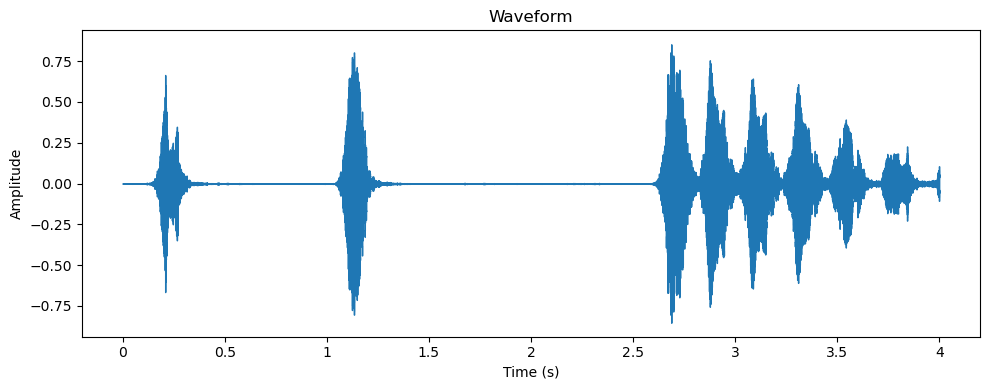

In [36]:
def display_waveform(audio_file, sr=44100):
    """
    Generates and displays the waveform of the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Display the waveform
display_waveform(input_audio_path)
ipd.Audio(input_audio_path)

This plot visually represents the audio signal's amplitude over time of a **dog bark**. It shows the raw audio signal in the time domain, with the horizontal axis representing time (in seconds) and the vertical axis representing the amplitude (intensity) of the sound at each point in time.

This plot is useful for understanding the overall structure and duration of the audio, as well as identifying silent or loud regions, transients, or periodic patterns. However, it does not provide detailed information about the frequency content of the audio, which is captured by other features like **spectrograms** or **MFCCs**.

##### Mel Spectogram for a specific audio file

A **Mel Spectrogram** shows the intensity of energy in different frequency bands over time. It is based on the Mel scale, which mimics the human perception of sound.

**How ​​to analyze?**

- **Frequency Components**:
  - Peaks at specific frequencies indicate tonal sounds (e.g., street music, siren).
  - Distributed energy indicates noise (e.g., jackhammer).

- **Changes over time**:
  - Stationary sounds (like enginge idling) will have constant spectrograms.
  - Dynamic sounds (like dog bark) will have rapid changes in intensity and frequency.

- **Compare between classes**:
  - Analyze how different sounds occupy the time-frequency space.

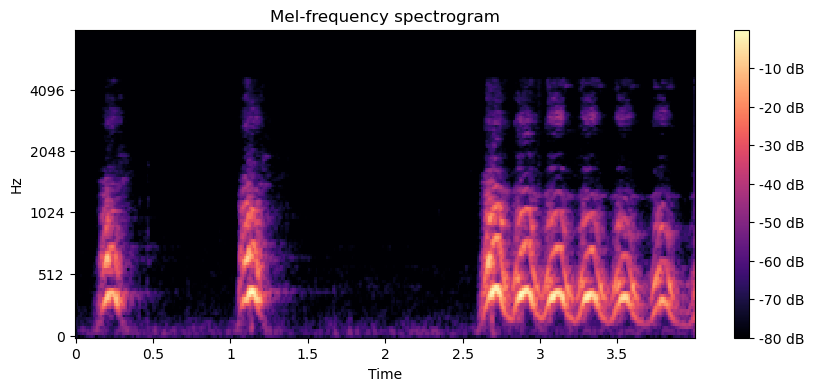

In [37]:
def display_spectrogram(audio_file, sr=44100, fmax=8000):
    """
    Generates and displays a mel-frequency spectrogram for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        fmax (int): Maximum frequency for the mel-frequency spectrogram (default: 8000).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)
    
    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

    # Display the image in the notebook
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Generate and display the spectrogram
display_spectrogram(input_audio_path)

This shows how the energy of audio signals is distributed over frequency and time (as explained above). 

The bright areas indicate **higher energy** concentrated at specific frequencies, which is characteristic of a dog bark. 

The pattern reveals distinct intervals with bursts of energy and repeating harmonic structures, reflecting the short, sharp, and periodic nature of a typical bark. The onsets and decays visible in the spectrogram align with the rhythmic and energetic nature of dog vocalizations.

##### MFCCs for a specific audio file

**Mel-Frequency Cepstral Coefficients (MFCCs)** are a reduction of the spectrogram into coefficients that represent the most relevant acoustic characteristics, especially in tasks such as speech and sound recognition.

**How ​​to analyze?**

- **Initial coefficients**:
  - Represent low-energy frequencies (general structure of the sound).

- **Higher coefficients**:
  - Capture rapid changes in the spectrum.

- **Patterns between classes**:
  - Sounds like "street music" may have coefficients with smooth variations.
  - Sounds like "barking" may have coefficients with abrupt changes.

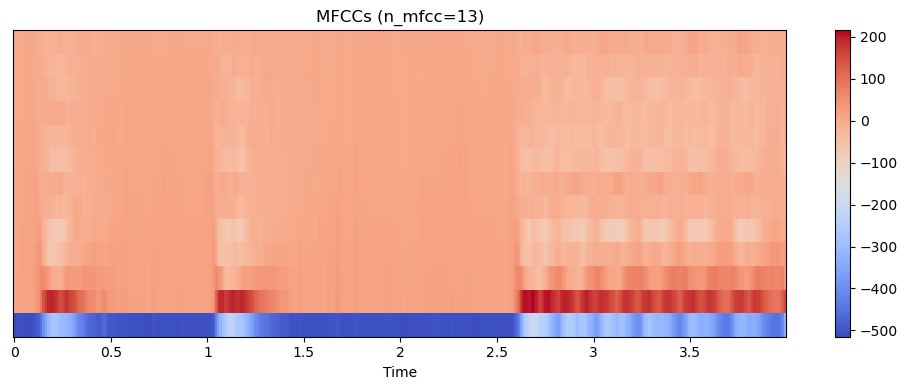

In [38]:
def display_mfcc(audio_file, sr=44100, n_mfcc=13):
    """
    Generates and displays the MFCCs for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        n_mfcc (int): Number of MFCCs to extract (default: 13).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.title(f'MFCCs (n_mfcc={n_mfcc})')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Display the MFCCs
display_mfcc(input_audio_path)

This one displays the first 13 Mel-frequency cepstral coefficients (MFCCs) extracted from the audio, which represent the **spectral characteristics** of the sound over time. These coefficients capture key features of the audio's **timbre and texture**, particularly reflecting the overall shape of the sound's frequency spectrum. The horizontal axis represents time, while the vertical axis corresponds to the 13 MFCCs. Since only the first 13 MFCCs are extracted, the plot focuses on the most significant features of the audio signal, which are crucial for tasks like speech recognition and audio classification.

##### Waveform and MelSpectogram for all audio data

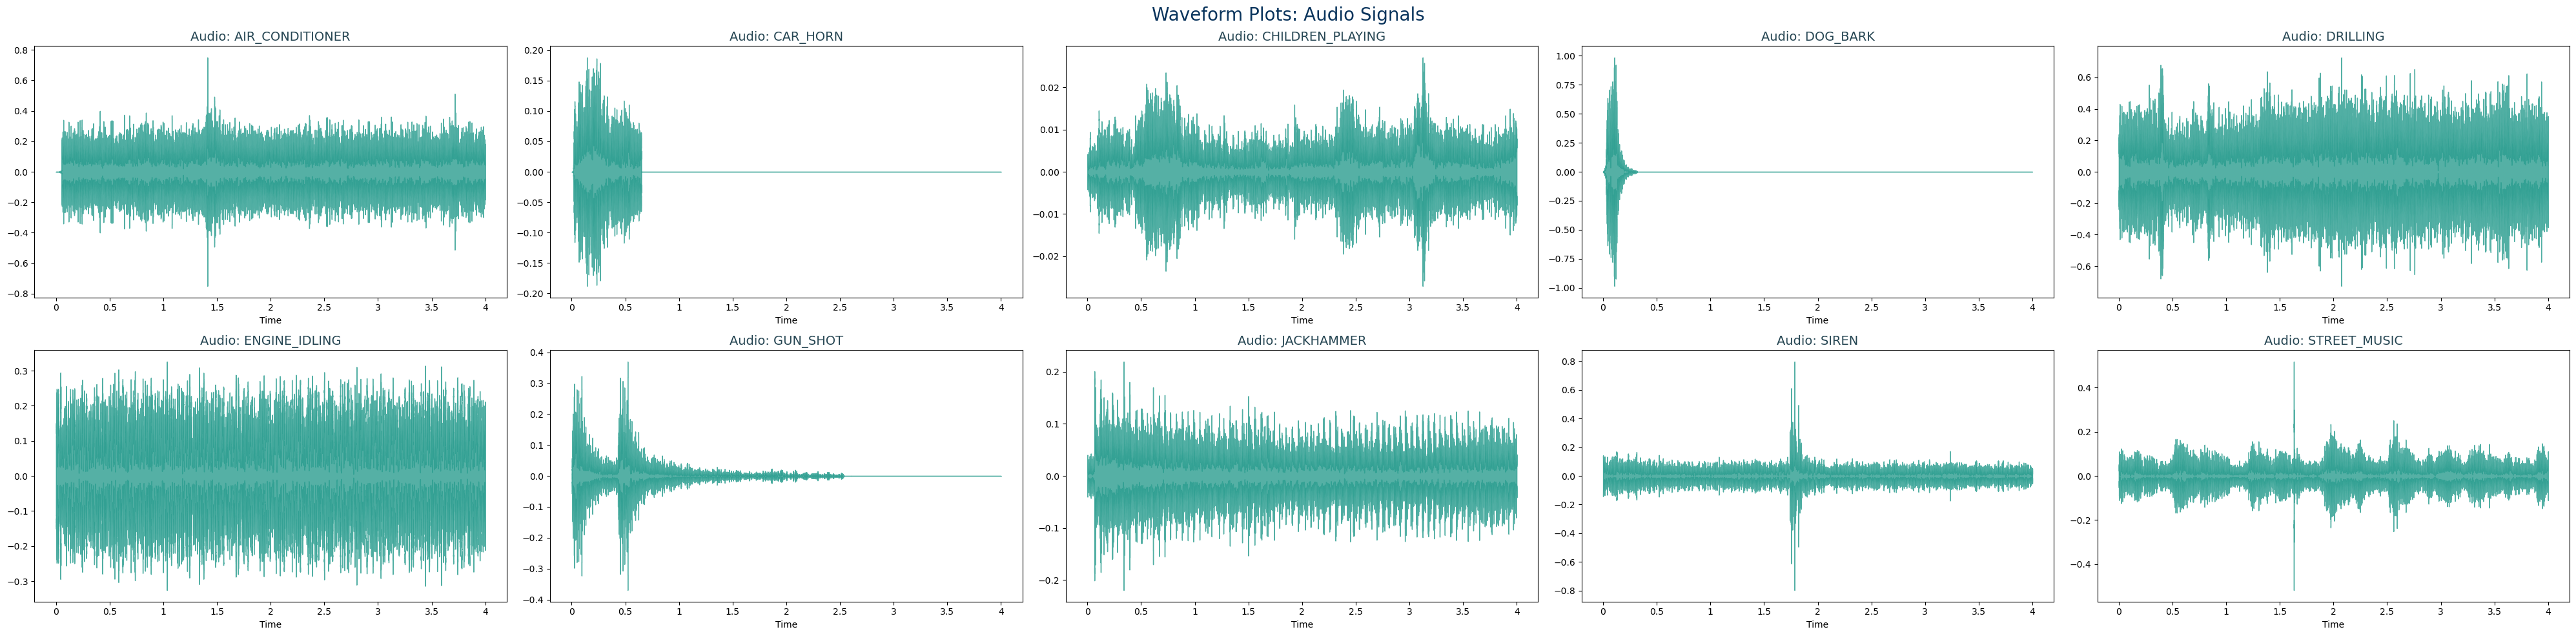

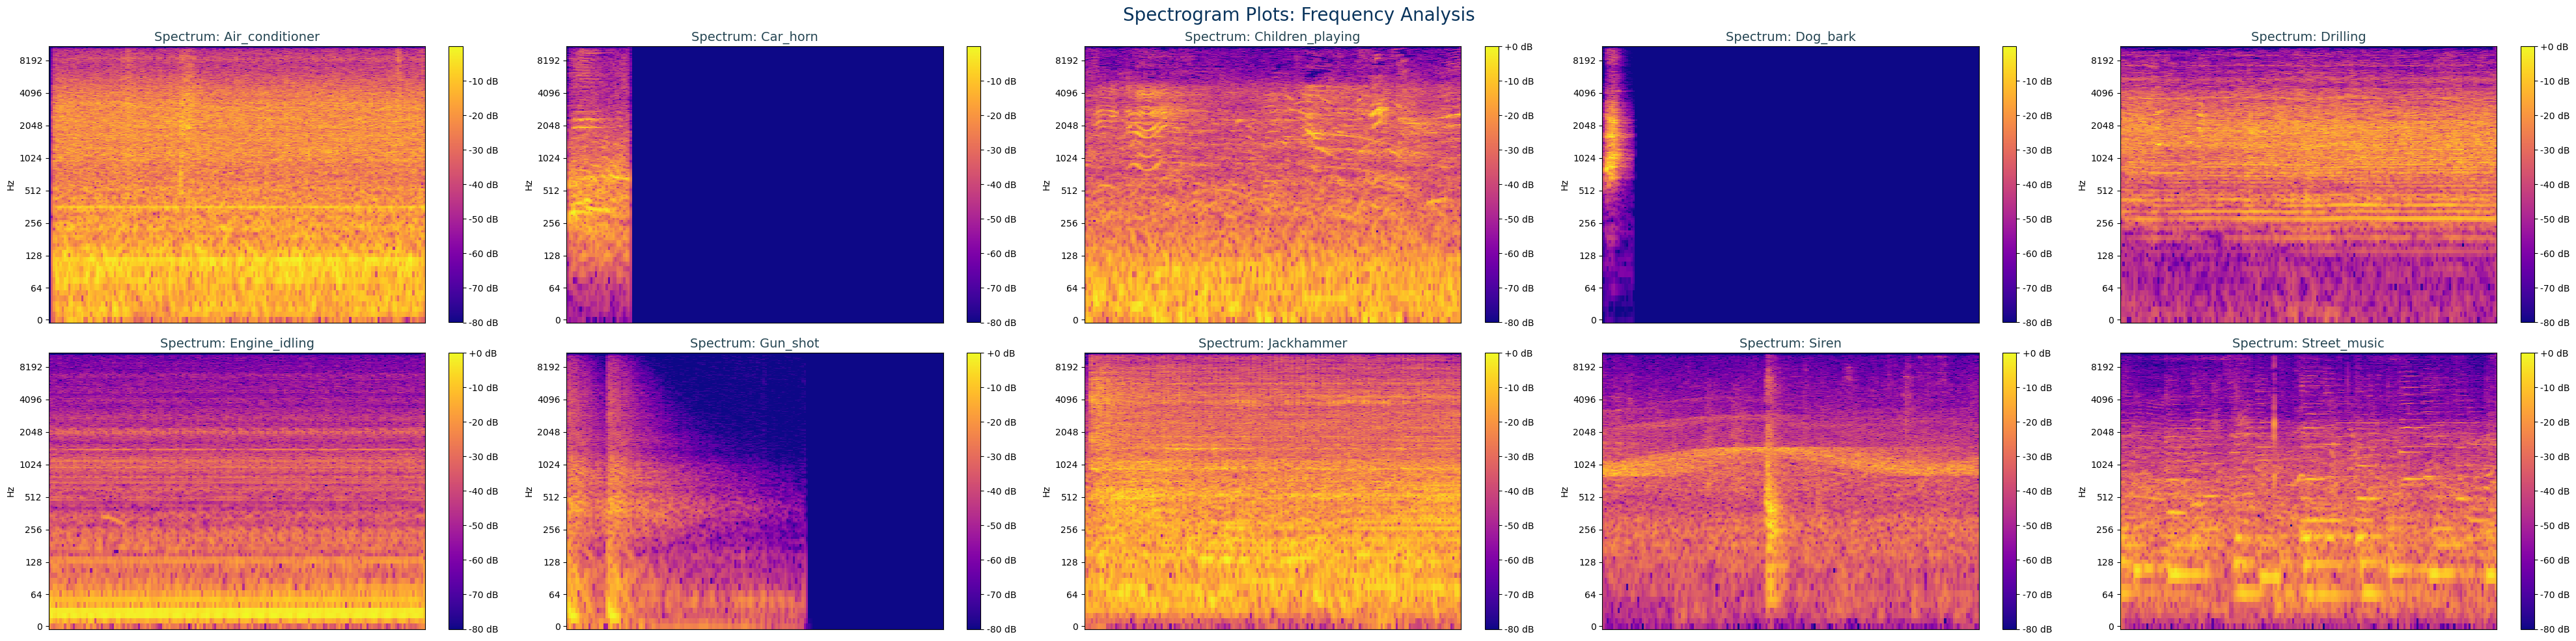

In [42]:
# Function to load audio files
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(fp, sr=None)  # sr=None to keep the original sample rate
        raw_sounds.append(X)
    return raw_sounds

# Function to plot the audio waveform
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10))  # Larger figure size for better viewing

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        librosa.display.waveshow(np.array(f), sr=22050, color='#2a9d8f', alpha=0.8, where='post')  # Blue-green color
        plt.title(f"Audio: {n.upper()}", fontsize=14, color='#264653')  # Titles with a darker tone
        i += 1

    fig.suptitle('Waveform Plots: Audio Signals', fontsize=20, color="#09345c")  # Main title in yellow
    plt.tight_layout()
    plt.show()

# Function to plot the audio spectrogram
def plot_spec(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10))  # Adjusted figure size

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        d = librosa.amplitude_to_db(np.abs(librosa.stft(f)), ref=np.max)
        librosa.display.specshow(d, y_axis='log', cmap='plasma')  # Spectrogram with 'plasma' color map
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrum: {n.capitalize()}", fontsize=14, color='#264653')  # Title with darker color
        i += 1

    fig.suptitle('Spectrogram Plots: Frequency Analysis', fontsize=20, color="#09345c")  # Main title
    plt.tight_layout()
    plt.show()

# Set CSV file path and get class list
path_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'
df = pd.read_csv(path_csv)

# Get list of classes from 'class' column in CSV
classes = list(np.unique(df['class']))

# Generate the list of audio file paths for viewing
sound_file_paths = [
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100852-0-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '100648-1-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100263-2-0-117.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100032-3-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold3', '103199-4-0-3.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '102857-5-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '102305-6-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '103074-7-1-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7', '102853-8-0-2.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7', '101848-9-0-9.wav')
]

# Upload the audios
raw_sounds = load_sound_files(sound_file_paths)

# Plot waveforms and spectrograms
plot_waves(classes, raw_sounds)
plot_spec(classes, raw_sounds)


##### Label Distribution Across Data Folds

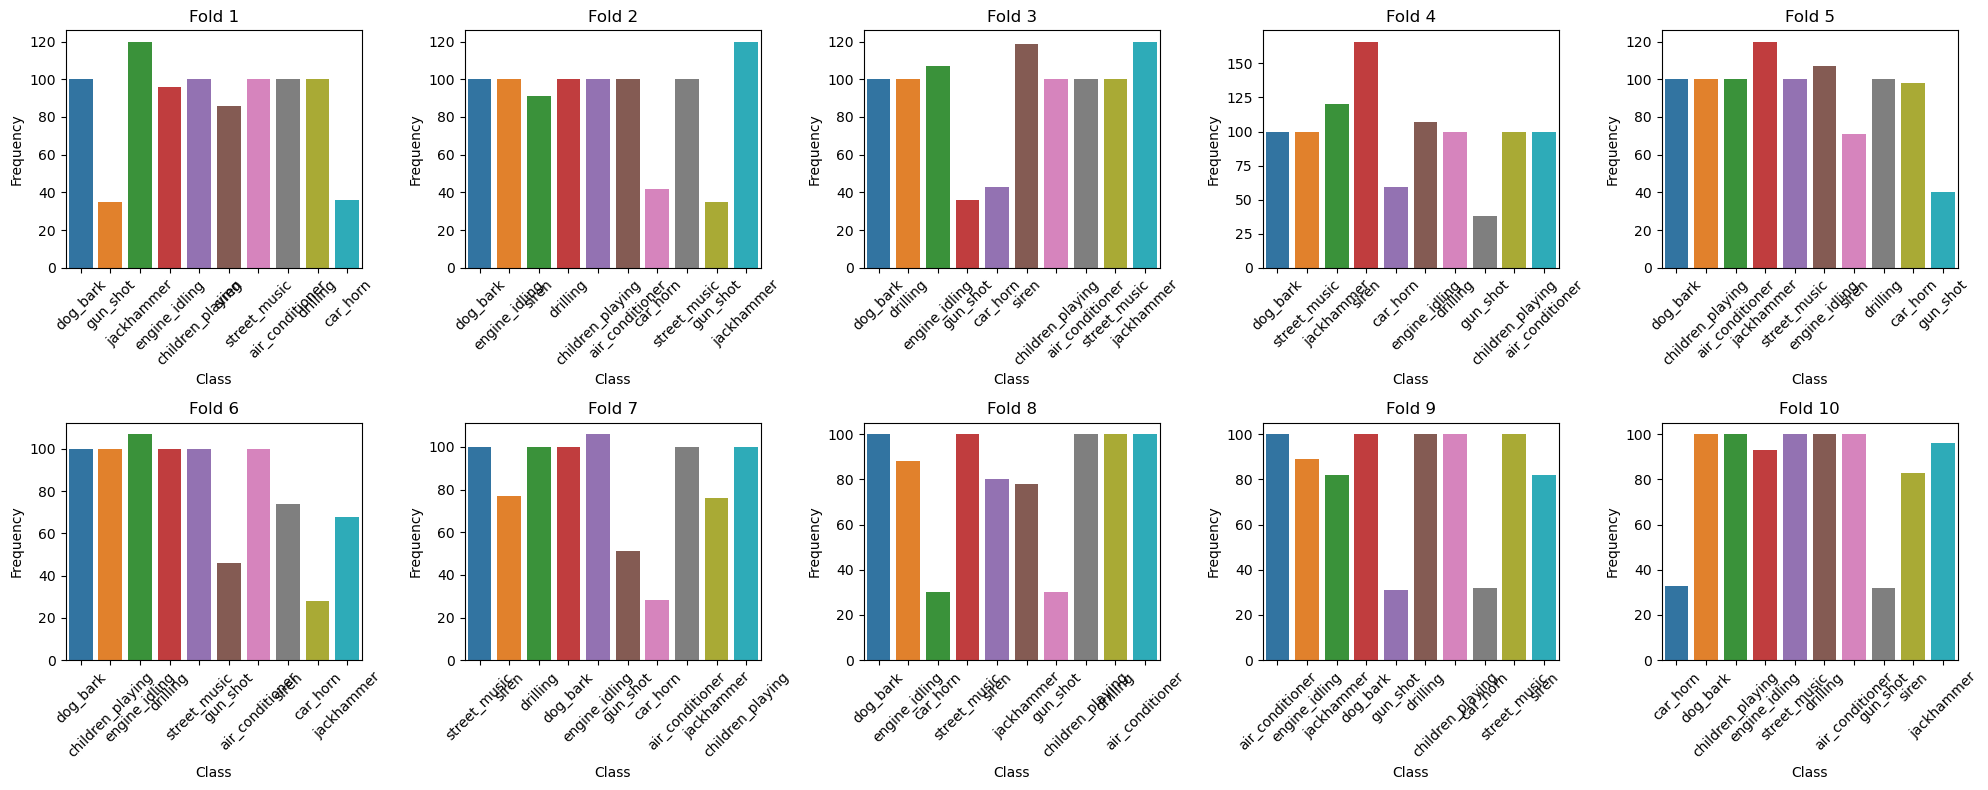

In [43]:
def plot_label_distribution_all_folds(csv_path, n_folds):
    """
    Plots the class distribution for each fold based on the UrbanSound8k metadata CSV file.
    
    :param csv_path: Path to the UrbanSound8k.csv file.
    :param n_folds: Total number of folds in the dataset.
    """
    # Load the CSV containing fold and class information
    df = pd.read_csv(csv_path)
    
    # Configure subplots
    nrows, ncols = 2, 5  # 2 rows and 5 columns for 10 folds
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    
    for fold_number in range(1, n_folds + 1):
        # Filter samples for the current fold
        fold_data = df[df['fold'] == fold_number]
        
        # Determine subplot position
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols
        
        # Plot histogram of classes
        sns.countplot(x=fold_data['class'], ax=axes[row, col])
        axes[row, col].set_title(f'Fold {fold_number}')
        axes[row, col].set_xlabel('Class')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
csv_path = "UrbanSound8K/metadata/UrbanSound8k.csv"
plot_label_distribution_all_folds(csv_path, 10)

The graphs show the **class distribution for each fold** in the UrbanSound8k dataset. Each subplot represents a **fold**, highlighting the frequency of audio samples per class. This helps evaluate class balance across folds for model training and validation.

#### 3.2.2. Cleaning the csvs <a name="cleaning"></a>
[[go back to the topic]](#data-cleaning)

In this section, we will perform data cleaning. This process will include the following steps:

- Check for Missing Values
- Check if there are any columns with object type
- Check for Duplicates
- Validate Column Data Types
- Normalization
- Label Encoding 

##### Missing values
[[go back to the topic]](#cleaning)

In [44]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print(f"  - Missing values detected:\n{missing_values[missing_values > 0]}")
    else:
        print("  - No missing values detected.")

##### Columns with object type
[[go back to the topic]](#cleaning)

In [45]:
def check_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    if object_columns.any():
        print(f"  - Columns with object data type: {object_columns.tolist()}")
    else:
        print("  - No columns with object data type detected.")

##### Duplicates
[[go back to the topic]](#cleaning)

In [46]:
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  - {duplicates} duplicate rows found.")
        df = df.drop_duplicates()  
    else:
        print("  - No duplicate rows detected.")
    return df  

def drop_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  - {duplicates} duplicate rows found.")
        df = df.drop_duplicates() 
    else:
        print("  - No duplicate rows detected.")
    return df

##### Column Data Types
[[go back to the topic]](#cleaning)

In [47]:
def validate_column_data_types(df):
    column_data_types = df.dtypes
    print(f"  - Column data types:\n{column_data_types}")

##### Normalization
[[go back to the topic]](#cleaning)

We opted for **MinMaxScaler** to normalize the audio features, as it scales the data to a fixed range (0-1), which is advantageous for neural networks. This choice was informed by insights from [this site](https://vitalflux.com/minmaxscaler-standardscaler-python-examples/), which highlights the benefits of using MinMaxScaler over StandardScaler for neural network applications.

In [48]:
def normalize_data(df):
    # Normalize numerical columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        scaler = MinMaxScaler()
        
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
        print(f"Normalized values:\n{df[numeric_columns].describe()}")
        print(f"  - Normalized numeric columns: {numeric_columns.tolist()}")

    if 'Label' in df.columns:
        # Extract the classID from each filename
        df['Label'] = df['Label'].apply(lambda x: int(x.split('-')[1]) if isinstance(x, str) and len(x.split('-')) > 1 else None)
        print(f"Updated 'Label' column to 'classID' values.")
    
    return df

##### Fourier_tempogram normalization
[[go back to the topic]](#cleaning)

Since **fourier_tempogram** didn't normalize, that is, the values of it were extremly high, we decided to do a single normalization function to handle that feature in specific. 

In [49]:
def normalize_fourier_tempogram(df):
    """
    Normalizes the 'fourier_tempogram' column in the DataFrame using MinMaxScaler.
    """
    if 'fourier_tempogram' in df.columns:
        scaler = MinMaxScaler()
        df[['fourier_tempogram']] = scaler.fit_transform(df[['fourier_tempogram']])
        print("  - 'fourier_tempogram' normalized.")
    else:
        print("  - 'fourier_tempogram' column not found. Skipping normalization.")
    return df


##### Label Encoding
[[go back to the topic]](#cleaning)

The primary reason for this choice was to reduce the dimensionality of the input data.
We used Label Encoding because neural networks in TensorFlow can process integer labels directly. One-Hot Encoding was unnecessary as it adds memory overhead without improving performance for this task.

In [50]:
def label_encode_data(df):
    """
    Performs Label Encoding on all object-type columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        df (pd.DataFrame): DataFrame with Label Encoding applied.
    """
    object_columns = df.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        for col in object_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f"  - Label Encoding applied to column: {col}")
    else:
        print("  - No columns found for Label Encoding.")
    return df

##### Putting it All Together
[[go back to the topic]](#cleaning)

In [51]:
folder_path = "datasets"
file_names = [f"urbansounds_features_fold{i}.csv" for i in range(1, 11)]
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

# Iterar sobre os arquivos e processá-los
for i, file_path in enumerate(file_paths, 1):
    print(f"Data cleaning for file: {file_path}")
    
    # Carregar o dataset
    df = pd.read_csv(file_path)
    
    # 1. Check for missing values
    check_missing_values(df)
    
    # 2. Check for object-type columns
    check_object_columns(df)
    
    # 3. Check for duplicates
    df = drop_duplicates(df)
    
    # 4. Validate column data types
    validate_column_data_types(df)
    
    # 5. Normalize numeric columns
    df = normalize_data(df)

    # 6. Apply Label Encoding
    df = label_encode_data(df)

    # 7. Normalize fourier_tempogram
    df = normalize_fourier_tempogram(df)
    
    # Save the cleaned DataFrame to the same file
    df.to_csv(file_path, index=False)
    print(f"  - Cleaned data saved to: {file_path}")
    print("\n" + "-" * 50 + "\n")

Data cleaning for file: datasets\urbansounds_features_fold1.csv
  - No missing values detected.
  - Columns with object data type: ['fourier_tempogram', 'Label']
  - No duplicate rows detected.
  - Column data types:
chroma_stft          float64
chroma_cens          float64
melspectogram        float64
rms                  float64
centroid             float64
bandwidth            float64
contrast             float64
flatness             float64
rolloff              float64
crossing_rate        float64
tempogram            float64
fourier_tempogram     object
mfcc_1               float64
mfcc_2               float64
mfcc_3               float64
mfcc_4               float64
mfcc_5               float64
mfcc_6               float64
mfcc_7               float64
mfcc_8               float64
mfcc_9               float64
mfcc_10              float64
mfcc_11              float64
mfcc_12              float64
mfcc_13              float64
mfcc_14              float64
mfcc_15              float64


##### Distribution of the classes on the generated datasets 
[[go back to the topic]](#cleaning)

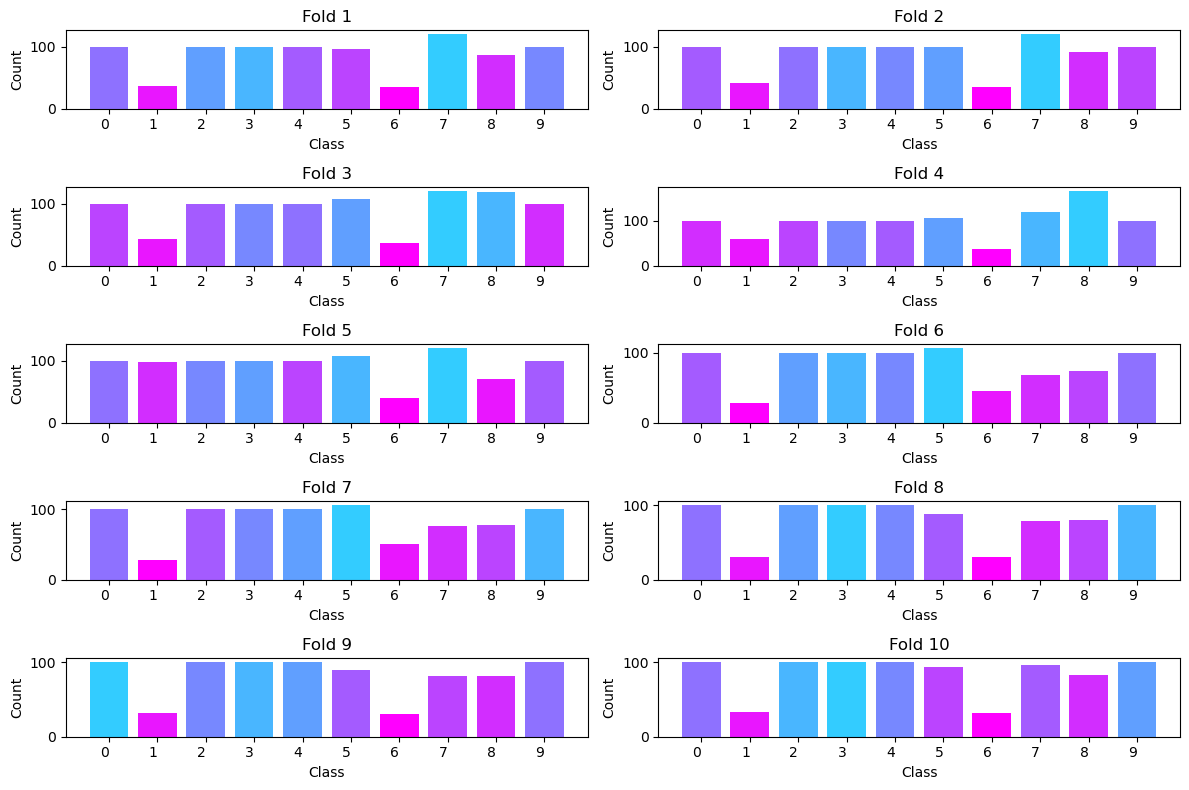

In [52]:
def plot_class_distribution_from_files(folder_path, file_names):
    datasets = []
    
    # Carregar datasets a partir dos arquivos
    for file_name in file_names:
        file_path = f"{folder_path}/{file_name}"
        datasets.append(pd.read_csv(file_path))
    
    rows = int(np.ceil(len(datasets) / 2))
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
    cmap = plt.get_cmap('cool')

    for fold, (df, ax) in enumerate(zip(datasets, axs.flat), start=1):
        # Supondo que a coluna de rótulos seja chamada 'Label'
        class_counts = df['Label'].value_counts()
        class_labels = class_counts.index
        class_values = class_counts.values
        colors = cmap(np.linspace(0.2, 1, len(class_labels)))
        ax.bar(class_labels, class_values, color=colors)
        ax.set(xlabel='Class', ylabel='Count', title=f'Fold {fold}')
        ax.set_xticks(class_labels)
        ax.set_xticklabels(class_labels, rotation=0, ha='right')

    # Ajuste final para exibição
    plt.tight_layout()
    plt.show()

# Caminho para a pasta e nomes dos arquivos
folder_path = "datasets"
file_names = [f"urbansounds_features_fold{i}.csv" for i in range(1, 11)]

# Chamar a função para plotar
plot_class_distribution_from_files(folder_path, file_names)


### 4. Modeling <a name="modeling"></a>
[[go back to the top]](#contents)

Now that we have completed the data understanding and preparation, we are ready to begin implementing the chosen models.

From now on, we will continue the project in **two different notebooks**. We will be able to access the file [[CNN]](./CNN.ipynb), which will document the procedure and implementation of the **CNN classifier**, while the file [[RNN]](./RNN.ipynb) will focus on the **RNN classifier**. This separation ensures clarity and facilitates tracking the workflow of each classifier.